In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow as tf
# from keras import layers


from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

import tensorflow.keras.backend as K


from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random



In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("Not enough GPU hardware devices available")
else:
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


2023-06-01 22:24:14.642292: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-06-01 22:24:14.701023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-01 22:24:14.701645: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 with Max-Q Design computeCapability: 7.5
coreClock: 1.23GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 357.69GiB/s
2023-06-01 22:24:14.701899: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-06-01 22:24:14.703807: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-01 22:24:14.705347: I tensorflow/st

In [3]:
# tf.debugging.set_log_device_placement(True)       # Will print the log information of every execution of tensorflow, mainly about 

In [4]:
#Size of our input images
# SIZE = 128        # It was this value at the beginning, but the image display was poor. 
SIZE = 224
# SIZE = 228          # It was 224, but in order for the current autoencoder model configuration work adequately, we changed it 228

# Setting the training and testing datasets 

ImageDataGenerator.flow_from_directory: Takes the path to a directory and generates batches of augmented data.

In [5]:
batch_size = 15
datagen = ImageDataGenerator(rescale=1./255) # Typically used for data augmentation. Here it is only rescaling the image pixels value to range 0 to 1 in decimals

train_generator = datagen.flow_from_directory(
    "../../Images/BottleStoodUp_atNight/Positive/",     # For home laptop
    # "../../../BottleStoodUp_atNight/Positive/",           # For work laptop
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'          # Class used for working with Autoencoders
    
    )

Found 179 images belonging to 1 classes.


In [6]:
validation_generator = datagen.flow_from_directory(
    "../../Images/BottleStoodUp_atNight/Positive_val/",     # For home laptop
    # "../../../BottleStoodUp_atNight/Positive_val/",           # For work lpatop   
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 30 images belonging to 1 classes.


In [7]:
anomaly_generator = datagen.flow_from_directory(
    "../../Images/BottleStoodUp_atNight/Anomalies2.0/",         # For home laptop
    # "../../../BottleStoodUp_atNight/Anomalies2.0/",           # For work lpatpo
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 6 images belonging to 1 classes.


In [8]:
test_set_generator = datagen.flow_from_directory(
    "../../Images/BottleStoodUp_atNight/Evaluation/",       # For home laptop
    # "../../../BottleStoodUp_atNight/Evaluation/",             # For work laptop  
    target_size=(SIZE, SIZE),
    batch_size=batch_size,
    shuffle = False,
    class_mode='input'
    )


Found 30 images belonging to 2 classes.


# Showing one sample of the training set images

Grabbing only one image of one batch of the training set.

In [9]:
images_in_batch = next(train_generator)[0]
print(type(images_in_batch))
print(len(images_in_batch))
print(tf.reduce_min(images_in_batch), tf.reduce_max(images_in_batch))

<class 'numpy.ndarray'>
15


2023-06-01 22:24:15.068382: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-06-01 22:24:15.091510: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2599990000 Hz
2023-06-01 22:24:15.092020: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9490001050 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-06-01 22:24:15.092036: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-06-01 22:24:15.156812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-01 22:24:15.157203: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x52d5950 initialized for platform CUDA (this does not guarantee that XLA will

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


In [10]:
print(images_in_batch.shape)

(15, 224, 224, 3)


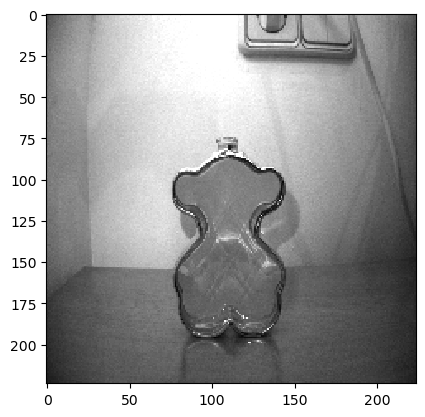

In [11]:
single_img = images_in_batch[0]
plt.imshow(single_img)

# Configuring the Autoencoder netwrok

In [12]:

# batch_size = 16
latent_dim = 32  # Number of latent dimension parameters

input_img = Input(shape=(SIZE, SIZE, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPool2D( (2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)

x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)

x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

shape_before_flattening = K.int_shape(x)
print(shape_before_flattening)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)

Z = Dense(latent_dim)(x)
print(K.int_shape(Z))

encoder = Model(input_img,Z)
encoder.summary()

(None, 28, 28, 1)
(None, 32)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 16)      4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 4)         580       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (No

In [13]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(Z)[1:])
x = Dense(56*56*4, activation='relu', name="intermediate_decoder", input_shape=(latent_dim,))(decoder_input)
# Expand to 12544 total pixels
x = Dense(12544, activation='sigmoid', name="original_decoder")(x)
x = Reshape((56,56,4),input_shape=(12544,))(x)

x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)

x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)


# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(Z)

decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
intermediate_decoder (Dense) (None, 12544)             413952    
_________________________________________________________________
original_decoder (Dense)     (None, 12544)             157364480 
_________________________________________________________________
reshape (Reshape)            (None, 56, 56, 4)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 56, 56, 3)         111       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 112, 112, 3)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 112, 112, 3)       84  

In [14]:
# VAE model statement
ae = Model(input_img,z_decoded)
ae.compile(optimizer='adam', loss='mse')

ae.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 16)      4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 4)         580       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 4)         0   

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
# run the model
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = ae.fit(train_generator, epochs=2000, validation_data=validation_generator, callbacks=[early_stopping],verbose=1)

Epoch 1/2000


2023-06-01 22:24:41.845202: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-06-01 22:24:42.045394: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


12/12 [==============================] - 1s 118ms/step - loss: 0.3948 - val_loss: 0.1590
Epoch 2/2000
12/12 [==============================] - 1s 82ms/step - loss: 0.1425 - val_loss: 0.0870
Epoch 3/2000
12/12 [==============================] - 1s 77ms/step - loss: 0.0780 - val_loss: 0.0493
Epoch 4/2000
12/12 [==============================] - 1s 79ms/step - loss: 0.0411 - val_loss: 0.0203
Epoch 5/2000
12/12 [==============================] - 1s 79ms/step - loss: 0.0180 - val_loss: 0.0089
Epoch 6/2000
12/12 [==============================] - 1s 78ms/step - loss: 0.0080 - val_loss: 0.0059
Epoch 7/2000
12/12 [==============================] - 1s 80ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 8/2000
12/12 [==============================] - 1s 78ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 9/2000
12/12 [==============================] - 1s 78ms/step - loss: 0.0051 - val_loss: 0.0054
Epoch 10/2000
12/12 [==============================] - 1s 76ms/step - loss: 0.0049 - val_loss: 0.0056
E

In [ ]:
# #Fit the model. 
# history = ae.fit(
#         train_generator,
#         # epochs=10,
#         epochs=200,
#         validation_data=validation_generator,
#         shuffle = True)

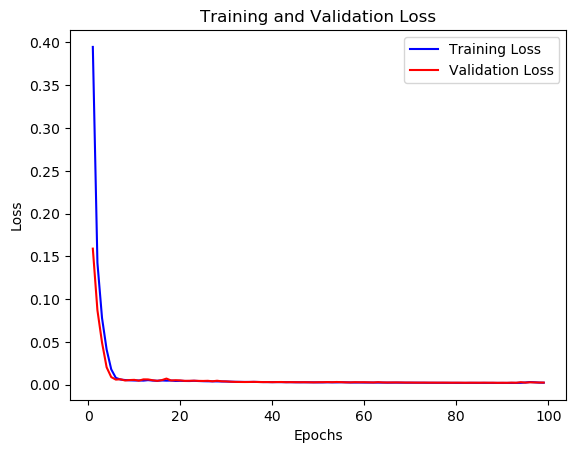

In [16]:

# Get the training and validation loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [27]:
model_version = 'NewAutoencoderModel9'
print(model_version)

NewAutoencoderModel9


In [28]:
ae.save(f"../../BottlesAnomalies_TFM/models/{model_version}")

2023-06-01 22:31:22.631574: W tensorflow/python/util/util.cc:329] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../../BottlesAnomalies_TFM/models/NewAutoencoderModel9/assets


In [29]:
print(type(ae))

<class 'tensorflow.python.keras.engine.training.Model'>


Loading the model that was previously saved


In [30]:
model = keras.models.load_model('../models/NewAutoencoderModel9')
print(type(model))

2023-06-01 22:31:29.935667: I tensorflow/stream_executor/cuda/cuda_driver.cc:763] failed to allocate 2.83G (3036914432 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


<class 'tensorflow.python.keras.engine.training.Model'>


Get all batches generated by the datagen and pick a batch for prediction

In [31]:
#Just to test the model. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
# while img_num <= train_generator.batch_index:   #gets each generated batch of size batch_size
while img_num < len(train_generator):        #I think this should be the correct while clause
    data = train_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1
    
print("number of batches are: ", img_num)


number of batches are:  12


In [32]:
print(len(data_batch))

12


Predict on the first batch of images. Do also notice that the prediction is being carried out over the images we used for training.

In [33]:
print(data_batch[0].shape)
predicted = model.predict(data_batch[0])  
print(predicted.shape)

(15, 224, 224, 3)
(15, 224, 224, 3)


The above is 15 length because it corresponds to the 15 predicted images of a batch. Recall that the predictions are reconstructions of the input images, since we are working with the autoencoder network.

In [34]:
single_img = data_batch[0][0]

In [35]:
print(single_img.shape)

(224, 224, 3)


In [36]:
random.randint(0, 2)

2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


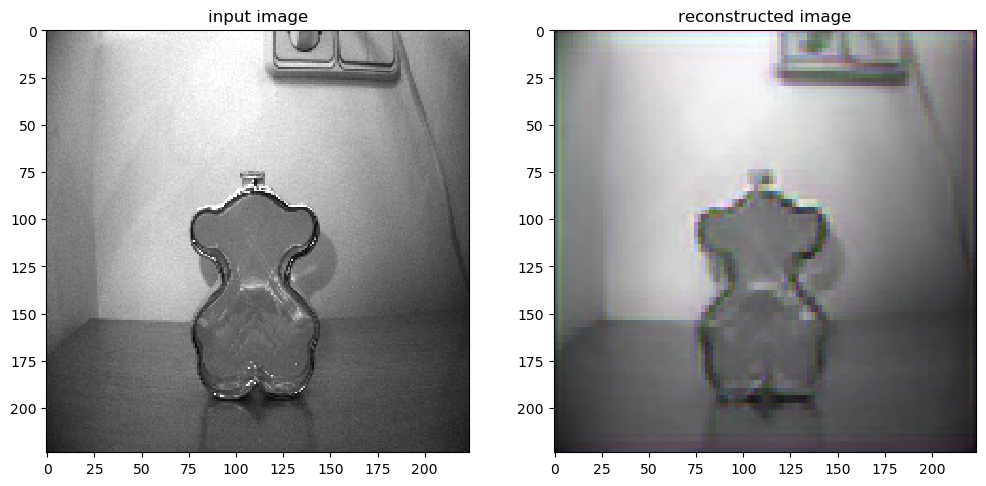

In [37]:
#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0]-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("input image")
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.title("reconstructed image")
plt.imshow(predicted[image_number])
plt.show()

THe reconstructed image is way much better now.


# Quantifying the reconstruction error

Let us examine the reconstruction error of our validation data (good/normal images) and the anomaly images

In [ ]:
validation_error = model.evaluate_generator(validation_generator)
print("Recon. error for the validation (normal) data is: ", validation_error)

Here above we see a vector with two components which happen to be the same between them. This is because in the model, when we define the outputs, the loss function type and the metric are the same parameter, the mse (mean square error).

This reconstruction error above should be very low, since the validation generator is full of normal images (good images)

Whereas the reconstruction error here below, for the "anomaly_generator" should be higher, since this dataset is comprised of full anomaly images.

In [ ]:
anomaly_error = model.evaluate_generator(anomaly_generator)
print("Recon. error for the anomaly data is: ", anomaly_error)

See that this error is slightly higher than the error in the validation dataset. This is good, but the difference is not that significant and this could result in wrong anomaly detections. Let's see some detections.

SIDENOTE: Additionally, we can check the train generator error according to the "evaluate_generator()" function.

In [ ]:
training_error = model.evaluate_generator(train_generator)
print("Recon. error for the training (non-anomaly) data is: ", training_error)

See that the above value does not correspond with the below mean reconstruction error of the training set that will be computed. It should at least be close, I think. This is something to check.

# Computing the reconstruction error without using the "evaluate_generator()" function

The following function computes the reconstrution error per each batch of images. It does, for each of the batches:
- Initialize a vector for storing the reconstruction errors.
- A for loop that traverses all the images contained in a batch.
    - Take the one image of the batch.
    - Add a new size dimension to the image.
    - Make a prediction of the selected image with the model that was built.
    - Evaluate the performance of the prediction, i.e. compute the prediction error.
    - Append the reconstruction error into a list.
- Compute the mean and std deviation of the error.
 

In [ ]:
def calc_recon_error(batch_images):   
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]):
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        reconstruction = model.predict([[img]])
        # reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]    # The batch_size parameter for the moment can be supressed. Results were seen to be the same
        # reconstruction_error = model.evaluate([reconstruction],[[img]])[0]                    # It included the [0] subscription but with this new model, the rec error is directly a float value, so no more need for subscription
        reconstruction_error = model.evaluate([reconstruction],[[img]])
        recon_error_list.append(reconstruction_error)   
    return recon_error_list

In [ ]:
total_rec_error = []
for i in range(len(train_generator)):        #I think this should be the correct while clause
    data = train_generator.next()
    total_rec_error.append(calc_recon_error(data[0]))
    
print("The list of rec. error contains ", len(total_rec_error), "batches of rec. errors")

In [ ]:
print(type(total_rec_error[0]))

In [ ]:
total_rec_error_list = [item for sublist in total_rec_error for item in sublist]
print(len(total_rec_error_list))

In [ ]:
na_average_recon_error = np.mean(np.array(total_rec_error_list))  
na_stdev_recon_error = np.std(np.array(total_rec_error_list)) 
min_prob = np.min(total_rec_error_list)
max_prob = np.max(total_rec_error_list)
print("THIS IS FOR THE TRAINING (NON-ANOMALY) IMAGES\n")
print("The average of the errors list is: ", na_average_recon_error)
print("The standard deviation of the errors list is: ", na_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

Compute the average and std dev. of recon. error for positive (anomalies) samples. 


In [ ]:
anomaly_batch = anomaly_generator.next()

In [ ]:
total_rec_error_anomalies = []
data = anomaly_generator.next()
total_rec_error_anomalies=calc_recon_error(data[0])
print(len(total_rec_error_anomalies))

In [ ]:
a_average_recon_error = np.mean(np.array(total_rec_error_anomalies))  
a_stdev_recon_error = np.std(np.array(total_rec_error_anomalies)) 
min_prob = np.min(total_rec_error_anomalies)
max_prob = np.max(total_rec_error_anomalies)
print("THIS IS FOR THE ANOMALY IMAGES\n")
print("The average of the errors list is: ", a_average_recon_error)
print("The standard deviation of the errors list is: ", a_stdev_recon_error)
print("The min value of the errors list is: ", min_prob)
print("The max value of the errors list is: ", max_prob)

See above that results are alreayd shit. The average reconstruction error for non-anomaly images is hihgher than the average for anomaly images

Below, we can see the plot of the reconstruction error values, of the non-anomaly list (blue) and the anomaly list (red).

In [ ]:
plt.figure(figsize=(10, 10))
val = 0. # this is the value where you want the data to appear on the y-axis.
plt.plot(total_rec_error_list, np.zeros_like(total_rec_error_list) + val, 'x')
plt.plot(total_rec_error_anomalies, np.zeros_like(total_rec_error_anomalies) + val, 'ro')
plt.show()

AT THIS POINT THE TEST COULD END. The reuslts are already worthless.